In [1]:
from math import factorial, exp
import matplotlib.pyplot as plt
import numpy as np

def offeredTraffic(calls_per_hour, hours_per_call): # A0
    return calls_per_hour*hours_per_call

def erlangB(n, A0):
    denom = 0
    for i in range(n+1):
        denom += (A0**i)/(factorial(i))
    E1 = ((A0**n)/factorial(n))/denom
    return E1

# def erlangC(n, A0):
#     denom = ((A0**n)/factorial(n))*(n/(n-A0))
#     for i in range(n):
#         denom += (A0**i)/factorial(i)
#     return ((A0**n)/factorial(n))*(n/(n-A0))/denom
def erlangC(n, A0):
    denomSum = 0
    for i in range(n):
        denomSum += (A0**i)/factorial(i)
    denom = A0**n + factorial(n)*(1-A0/n)*denomSum
    return (A0**n)/denom

def meanCallDelay(n, A0, meanCallDuration, probDelay):
    return probDelay*meanCallDuration/(n-A0)

def meanQueuedDelay(n, A0, meanCallDuration):
    return meanCallDuration/(n-A0)

def erlangC_GOS(n, A0, meanCallDuration, probDelay, maxDelay=0):
    return probDelay*exp(-(n-A0)*maxDelay/meanCallDuration)


In [2]:
def trafficSimulation(numChannels, numCalls, meanCallDuration, requeue=False, maxDelay=0):

    callDurations = np.random.exponential(scale=meanCallDuration, size=numCalls)
    callStarts = np.random.uniform(size=numCalls)
    # if requeue == False:
    #     callStarts = np.random.uniform(size=numCalls)
    # else:
    #     callStarts = np.random.poisson(lam=meanCallDuration, size=numCalls)/2
    #     print(callStarts.mean())
        
    callStarts.sort()
    # plt.plot(callStarts)
    # plt.show()
    # print(callStarts.max())
    # Calls = Numpy array of [[call0_start call0_end]; [call1_start call1_end];...
    calls = np.stack((callStarts, np.add(callStarts,callDurations)),axis=1)

    channelFreeTimes = np.zeros(numChannels)
    
    time = 0
    callsFailed = 0
    callsDelayed = 0
    totalDelay = 0
    for i, call in enumerate(calls):
        time = call[0]
        channelFound = False
        # print("\nTime:", time)
        # print("channelFreeTimes", channelFreeTimes)
        for j in range(numChannels):
            if not(channelFound):
                if channelFreeTimes[j] <= time:
                    # print("Channel {} free. Adding call end time {}".format(j, call[1]))
                    channelFreeTimes[j] = call[1]
                    channelFound = True
                    # print("channelFreeTimes", channelFreeTimes)
        if channelFound == False:
            if requeue == False:
                callsFailed += 1
                # print("Call {} ({}) failed.\n".format(i,call))
            else:
                nextCallFinishTime = channelFreeTimes.min()
                totalDelay += nextCallFinishTime-call[0]
                if totalDelay>maxDelay:
                    callsDelayed += 1
                    # time = nextCallFinishTime # go to next call finish time
                    indices = np.where(channelFreeTimes == nextCallFinishTime)
                    index = indices[0][0]
                    channelFreeTimes[index] = call[1]
                    # print("Call {} delayed, waited until time = {} for channel {},{}".format(i,time,indices,index))
                    # print("Channel {} free. Adding call end time {}".format(index, call[1]))
                    # print("channelFreeTimes", channelFreeTimes)

    if requeue == False:
        # print("False")
        return callsFailed/numCalls, callsFailed
    else:
        return callsDelayed/numCalls, callsDelayed, totalDelay


In [3]:
meanCallDuration = 3/60# 3 mins in hrs
n = 54

# minNumCalls = 1
# maxNumCalls = 2000
# numTests = 21
# simulationCallAmounts = np.concatenate((np.linspace(minNumCalls, maxNumCalls, numTests), np.linspace(2500, 6000, 8))).astype(np.int)
simulationCallAmounts = np.linspace(0, 3000, 16).astype(np.int)
# simulationCallAmounts = np.linspace(10, 300, 30).astype(np.int)
# simulationCallAmounts = np.linspace(500, 500, 1).astype(np.int)

repetitionsPerSimulation = 50
print(simulationCallAmounts)

[   0  200  400  600  800 1000 1200 1400 1600 1800 2000 2200 2400 2600
 2800 3000]


In [4]:
erlangBs = np.zeros(simulationCallAmounts.shape)
erlangCs = np.zeros(simulationCallAmounts.shape)
GOS_simulated = np.zeros(simulationCallAmounts.shape)
meanCallDelays = np.zeros(simulationCallAmounts.shape)
meanQueuedDelays = np.zeros(simulationCallAmounts.shape)

print("# Calls:\tErlang B:\tErlang C:\tSimulation:\tCall Delays\tQueued Delays")
for i, numCalls in enumerate(simulationCallAmounts):
    A0 = offeredTraffic(numCalls, meanCallDuration)
    erlangBs[i] = erlangB(n, A0)*100
    erlangCs[i] = erlangC(n, A0)*100
    meanCallDelays[i] = meanCallDelay(n, A0, meanCallDuration, erlangCs[i])
    meanQueuedDelays[i] = meanQueuedDelay(n, A0, meanCallDuration)
    
    totalFailRate, totalFailCount = 0, 0
    for j in range(repetitionsPerSimulation):
        failRate, failsCount = trafficSimulation(n, numCalls, meanCallDuration)
        totalFailRate += failRate
        totalFailCount += failsCount
    meanFailRate = totalFailRate/repetitionsPerSimulation
    meanFailCount = totalFailCount/repetitionsPerSimulation
    GOS_simulated[i] = meanFailRate*100
    # print("Call fail rate in {} simulations = {}% (mean of {} fails in {} calls)\n".format(repetitionsPerSimulation, GOS_simulated[i], meanFailCount, numCalls))


# for i, numCalls in enumerate(simulationCallAmounts):
    print("{}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}".format(numCalls,erlangBs[i], erlangCs[i], GOS_simulated[i], meanCallDelays[i], meanQueuedDelays[i]))

# Calls:	Erlang B:	Erlang C:	Simulation:	Call Delays	Queued Delays
0		0.00		0.00		nan		0.00		0.00
200		0.00		0.00		0.00		0.00		0.00
400		0.00		0.00		0.00		0.00		0.00
600		0.00		0.01		0.00		0.00		0.00
800		0.61		2.30		0.49		0.01		0.00
1000		6.25		47.36		5.17		0.59		0.01
1200		16.41		230.41		14.78		-1.92		-0.01
1400		26.34		583.69		24.43		-1.82		-0.00
1600		34.67		1078.22		32.93		-2.07		-0.00
1800		41.48		1677.74		39.54		-2.33		-0.00
2000		47.08		2354.33		45.05		-2.56		-0.00
2200		51.73		3088.30		50.12		-2.76		-0.00
2400		55.65		3865.87		54.13		-2.93		-0.00
2600		58.99		4677.25		57.39		-3.08		-0.00
2800		61.86		5515.33		60.21		-3.21		-0.00
3000		64.36		6374.84		63.00		-3.32		-0.00


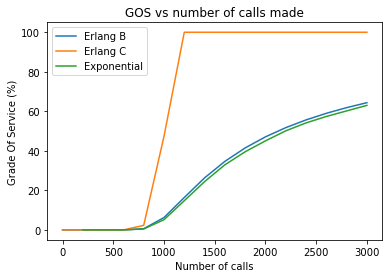

In [5]:
# print("Erlang B:\t\t\t Simulation:")
# for i, numCalls in enumerate(simulationCallAmounts):
#     print(GOS_erlang[i], "\t\t", GOS_simulated[i])

plt.plot(simulationCallAmounts, erlangBs, label='Erlang B')
plt.plot(simulationCallAmounts, np.clip(erlangCs,0,100), label='Erlang C')
plt.plot(simulationCallAmounts, GOS_simulated, label='Exponential')
plt.xlabel('Number of calls')
plt.ylabel('Grade Of Service (%)')
plt.title("GOS vs number of calls made")
plt.legend()
plt.show()

# plt.plot(simulationCallAmounts, np.clip(meanCallDelays,0,1)*60, label='meanCallDelays')
# plt.plot(simulationCallAmounts, np.clip(meanQueuedDelays,0,1)*60, label='meanQueuedDelays')
# plt.xlabel('Number of calls')
# plt.ylabel('Mean Delay (mins)')
# plt.legend()
# plt.show()

In [6]:
erlangBs = np.zeros(simulationCallAmounts.shape)
erlangCs = np.zeros(simulationCallAmounts.shape)
meanCallDelays = np.zeros(simulationCallAmounts.shape)
meanQueuedDelays = np.zeros(simulationCallAmounts.shape)
simProbDelay = np.zeros(simulationCallAmounts.shape)
pMaxDelays = np.zeros(simulationCallAmounts.shape)
maxDelay=0
print("# Calls:\tErlang C:\tSimulation:\tCall Delays\tQueued Delays\tSim # Delayed:\tSim Delay Durations:")
for i, numCalls in enumerate(simulationCallAmounts):
    A0 = offeredTraffic(numCalls, meanCallDuration)
    erlangBs[i] = erlangB(n, A0)*100
    erlangCs[i] = erlangC(n, A0)*100
    pMaxDelays[i] = erlangC_GOS(n, A0, meanCallDuration, erlangCs[i], maxDelay=maxDelay)
    meanCallDelays[i] = meanCallDelay(n, A0, meanCallDuration, erlangCs[i])
    meanQueuedDelays[i] = meanQueuedDelay(n, A0, meanCallDuration)
    
    totalProbDelay, totalDelayCount, totalDelay = 0, 0, 0
    for j in range(repetitionsPerSimulation):
        probDelay, delayCount, delay = trafficSimulation(n, numCalls, meanCallDuration, requeue=True, maxDelay=maxDelay)
        totalProbDelay += probDelay
        totalDelayCount += delayCount
        totalDelay += delay
    meanProbDelay = totalProbDelay/repetitionsPerSimulation
    meanDelayCount = totalDelayCount/repetitionsPerSimulation
    meanDelay = totalDelay/repetitionsPerSimulation
    simProbDelay[i] = meanProbDelay*100
    # print("Call fail rate in {} simulations = {}% (mean of {} fails in {} calls)\n".format(repetitionsPerSimulation, GOS_simulated[i], meanFailCount, numCalls))


# for i, numCalls in enumerate(simulationCallAmounts):
    print("{}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}".format(numCalls, pMaxDelays[i], simProbDelay[i], meanCallDelays[i], meanQueuedDelays[i], meanDelayCount, meanDelay*60))

# Calls:	Erlang C:	Simulation:	Call Delays	Queued Delays	Sim # Delayed:	Sim Delay Durations:
0		0.00		nan		0.00		0.00		0.00		0.00
200		0.00		0.00		0.00		0.00		0.00		0.00
400		0.00		0.00		0.00		0.00		0.00		0.00
600		0.01		0.00		0.00		0.00		0.00		0.00
800		2.30		1.46		0.01		0.00		11.68		1.66
1000		47.36		24.80		0.59		0.01		248.00		62.38
1200		230.41		69.34		-1.92		-0.01		832.12		359.12
1400		583.69		88.75		-1.82		-0.00		1242.56		883.58
1600		1078.22		92.93		-2.07		-0.00		1486.80		1433.11
1800		1677.74		94.25		-2.33		-0.00		1696.48		1991.27
2000		2354.33		95.10		-2.56		-0.00		1901.98		2543.29
2200		3088.30		95.72		-2.76		-0.00		2105.74		3127.30
2400		3865.87		96.22		-2.93		-0.00		2309.16		3711.77
2600		4677.25		96.59		-3.08		-0.00		2511.34		4282.78
2800		5515.33		96.83		-3.21		-0.00		2711.12		4885.77
3000		6374.84		97.16		-3.32		-0.00		2914.72		5421.25


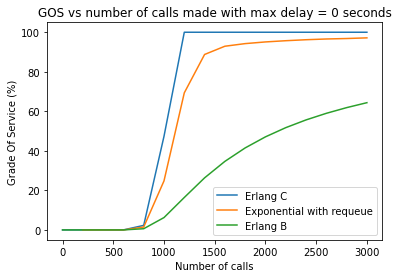

In [7]:
plt.plot(simulationCallAmounts, np.clip(erlangCs,0,100), label='Erlang C')
plt.plot(simulationCallAmounts, np.clip(simProbDelay,0,100), label='Exponential with requeue')
plt.plot(simulationCallAmounts, erlangBs, label='Erlang B')


plt.xlabel('Number of calls')
plt.ylabel('Grade Of Service (%)')
plt.title("GOS vs number of calls made with max delay = {} seconds".format(str(maxDelay*3600)))
plt.legend()
plt.show()

# plt.plot(simulationCallAmounts, np.clip(meanCallDelays,0,1)*60, label='meanCallDelays')
# plt.plot(simulationCallAmounts, np.clip(meanQueuedDelays,0,1)*60, label='meanQueuedDelays')
# plt.xlabel('Number of calls')
# plt.ylabel('Mean Delay (mins)')
# plt.legend()
# plt.show()